In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) 

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

RDKit WARNING: [02:04:18] Enabling RDKit 2019.09.3 jupyter extensions
[02:04:18] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score


In [3]:
# from rdkit.Chem import rdMolDescriptors, MolSurf
# from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

number of all smiles:  93087


number of successfully processed smiles:  93087


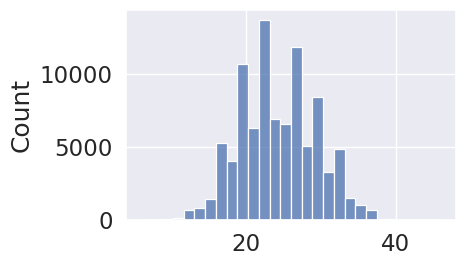

In [4]:
task_name = 'muv'
tasks = [
    "MUV-466","MUV-548","MUV-600","MUV-644","MUV-652","MUV-689","MUV-692","MUV-712","MUV-713","MUV-733","MUV-737","MUV-810","MUV-832","MUV-846","MUV-852","MUV-858","MUV-859"
]
raw_filename = "../data/muv.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.histplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

# print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [5]:
random_seed = 68
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.2
fingerprint_dim = 250

radius = 3
T = 2
weight_decay = 3.5 # also known as l2_regularization_lambda
learning_rate = 3.7
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<151]
# uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>150]

# smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

feature dicts file saved as ../data/muv.pickle


,MUV-466,MUV-548,MUV-600,MUV-644,MUV-652,MUV-689,MUV-692,MUV-712,MUV-713,MUV-733,MUV-737,MUV-810,MUV-832,MUV-846,MUV-852,MUV-858,MUV-859,mol_id,smiles,cano_smiles


In [7]:
weights = []
for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    negative_test = negative_df.sample(frac=1/10,random_state=random_seed)
    negative_valid = negative_df.drop(negative_test.index).sample(frac=1/9,random_state=random_seed)
    negative_train = negative_df.drop(negative_test.index).drop(negative_valid.index)
    
    positive_test = positive_df.sample(frac=1/10,random_state=random_seed)
    positive_valid = positive_df.drop(positive_test.index).sample(frac=1/9,random_state=random_seed)
    positive_train = positive_df.drop(positive_test.index).drop(positive_valid.index)
    
    weights.append([(positive_test.shape[0]+negative_test.shape[0])/negative_test.shape[0],\
                    (positive_test.shape[0]+negative_test.shape[0])/positive_test.shape[0]])
    train_df_new = pd.concat([negative_train,positive_train])
    valid_df_new = pd.concat([negative_valid,positive_valid])
    test_df_new = pd.concat([negative_test,positive_test])
    if i==0:
        train_df = train_df_new
        test_df = test_df_new
        valid_df = valid_df_new
    else:
        train_df = pd.merge(train_df, train_df_new, on='smiles', how='outer') 
        test_df = pd.merge(test_df, test_df_new, on='smiles', how='outer')
        valid_df = pd.merge(valid_df, valid_df_new, on='smiles', how='outer')

In [8]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

1790038
atom_fc.weight torch.Size([250, 39])
atom_fc.bias torch.Size([250])
neighbor_fc.weight torch.Size([250, 49])
neighbor_fc.bias torch.Size([250])
GRUCell.0.weight_ih torch.Size([750, 250])
GRUCell.0.weight_hh torch.Size([750, 250])
GRUCell.0.bias_ih torch.Size([750])
GRUCell.0.bias_hh torch.Size([750])
GRUCell.1.weight_ih torch.Size([750, 250])
GRUCell.1.weight_hh torch.Size([750, 250])
GRUCell.1.bias_ih torch.Size([750])
GRUCell.1.bias_hh torch.Size([750])
GRUCell.2.weight_ih torch.Size([750, 250])
GRUCell.2.weight_hh torch.Size([750, 250])
GRUCell.2.bias_ih torch.Size([750])
GRUCell.2.bias_hh torch.Size([750])
align.0.weight torch.Size([1, 500])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 500])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 500])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([250, 250])
attend.0.bias torch.Size([250])
attend.1.weight torch.Size([250, 250])
attend.1.bias torch.Size([250])
attend.2.weight torch.Size([250, 250]

In [9]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        model.zero_grad()
        # Step 4. Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
        
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)            
    eval_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    eval_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     eval_precision = [precision_score(y_val_list[i],
#                                      (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
#     eval_recall = [recall_score(y_val_list[i],
#                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    eval_loss = np.array(losses_list).mean()
    
    return eval_roc, eval_prc, eval_loss # eval_precision, eval_recall, 


In [10]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_prc, train_loss = eval(model, train_df)
    valid_roc, valid_prc, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    train_prc_mean = np.array(train_prc).mean()
    valid_prc_mean = np.array(valid_prc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.75:
             torch.save(model.state_dict(), 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
        +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
        +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        +"train_prc_mean"+":"+str(train_prc_mean)+'\n'\
        +"valid_prc_mean"+":"+str(valid_prc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >6) and (epoch - best_param["loss_epoch"] >8):        
        break
        
    train(model, train_df, optimizer, loss_function)


EPOCH:	0
train_roc:[0.6181295501663371, 0.5821796046893248, 0.5436387282417645, 0.6560242683797288, 0.6054582591887516, 0.4351853923784376, 0.5853521638727335, 0.5630604296199151, 0.38774203020904074, 0.4670256815855588, 0.5237629267207828, 0.6351518689851106, 0.5602474592194038, 0.5169008088548318, 0.6769328833617044, 0.5219234228257184, 0.5677385804041433]
valid_roc:[0.7708755345487284, 0.5859959211420802, 0.4748299319727891, 0.6312542837559972, 0.6650975117686617, 0.5573095401509952, 0.862879306411134, 0.22786277236903105, 0.5070898041863605, 0.6552901023890785, 0.44929513415188727, 0.514944102213096, 0.8525728597449909, 0.463669391462307, 0.4425444596443228, 0.5805649717514124, 0.8148777173913043]
train_roc_mean:0.5556737681590169
valid_roc_mean:0.5915854908855398
train_prc_mean:0.0025383206984564716
valid_prc_mean:0.0037302276516954615



EPOCH:	1
train_roc:[0.5783633061729585, 0.7393152284789261, 0.46846473323127513, 0.7914275517487509, 0.7063180318404543, 0.5510602907501473, 0.6265145683658342, 0.6907455540896056, 0.6140620698515242, 0.6250387705095996, 0.7279217168909151, 0.6324205328057833, 0.6584322600848349, 0.8304952462040585, 0.7610925687780148, 0.5898572839724594, 0.3836474783494651]
valid_roc:[0.658564033310826, 0.692952639927487, 0.6111111111111112, 0.7052775873886225, 0.6538892624971979, 0.8414550446122169, 0.8254620123203286, 0.60778859527121, 0.6941255908170156, 0.43936291240045505, 0.8547066848567532, 0.43714350901209215, 0.6247723132969034, 0.6780199818346957, 0.7437300501595987, 0.7432768361581921, 0.375679347826087]
train_roc_mean:0.645598658360271
valid_roc_mean:0.6580775007529879
train_prc_mean:0.004249242010058963
valid_prc_mean:0.005024718175284635



EPOCH:	2
train_roc:[0.6133865290969577, 0.7470174297414367, 0.4871771701536542, 0.7919307637401856, 0.7219167120364516, 0.5729001171056263, 0.632993357281332, 0.7138856190303136, 0.6486978545341091, 0.6425048850842096, 0.7500500389191593, 0.6602284728316649, 0.670579255273721, 0.8552859372782744, 0.7755283326023772, 0.6090679228036032, 0.5787676175921209]
valid_roc:[0.6698176907494936, 0.6952186721051439, 0.6251700680272109, 0.7128169979437972, 0.6680116565792423, 0.894074582475406, 0.7880447182295232, 0.6309689383402874, 0.6907494935854153, 0.4536973833902162, 0.8665302410186448, 0.4953228382386493, 0.6468579234972678, 0.752724795640327, 0.7747378020975833, 0.7548022598870057, 0.335258152173913]
train_roc_mean:0.674818706770894
valid_roc_mean:0.6738120125870074
train_prc_mean:0.0049238952147844265
valid_prc_mean:0.006158615462020448



EPOCH:	3
train_roc:[0.6219243688025329, 0.7532523690551868, 0.49062694902761245, 0.7957530335474661, 0.7282197627129792, 0.5839169967255178, 0.6358157999771924, 0.7281220126879291, 0.6580175087635582, 0.6616226233677616, 0.7468438415063569, 0.6660295408231567, 0.6907756141999033, 0.8697850148999575, 0.7928519925368142, 0.6194583278045616, 0.6128926812701647]
valid_roc:[0.6704929101958137, 0.6997507364604578, 0.6083900226757369, 0.7023075165638566, 0.6749607711275498, 0.9153511782200869, 0.7634040611453342, 0.6481223922114047, 0.6828719333783478, 0.4782707622298066, 0.8667576170986813, 0.512890714122747, 0.6878415300546448, 0.8040417801998183, 0.8043775649794802, 0.7491525423728814, 0.5550271739130435]
train_roc_mean:0.6856416728063912
valid_roc_mean:0.6955300709970406
train_prc_mean:0.005383670758028154
valid_prc_mean:0.006372784641249891



EPOCH:	4
train_roc:[0.6354925027722867, 0.7533041112901557, 0.48274224641378916, 0.7923197715917202, 0.7435480511698096, 0.5856773105984321, 0.6427293591059413, 0.7435355554326616, 0.6715143061647733, 0.6871762662448435, 0.7744838578153378, 0.6960203186125036, 0.6988143023884761, 0.8750532141336739, 0.8072543058270831, 0.6174753416780928, 0.4756197996264221]
valid_roc:[0.645734863830745, 0.701790165420349, 0.5897959183673469, 0.6447338359607037, 0.6902039901367407, 0.9126058110272248, 0.7109285877253022, 0.6740843764487714, 0.6902993472878685, 0.5465301478953356, 0.8735788994997726, 0.56787588409765, 0.7324681238615665, 0.8396911898274296, 0.8176014591883264, 0.7283615819209039, 0.38519021739130427]
train_roc_mean:0.6872212129921178
valid_roc_mean:0.691263199993373
train_prc_mean:0.0066045435542894625
valid_prc_mean:0.006817190015071861



EPOCH:	5
train_roc:[0.6338552464522765, 0.7709629969102494, 0.5293027442308782, 0.806538187009279, 0.7517365361356636, 0.5954485443845241, 0.6537625441897593, 0.7606318683489102, 0.6608585534164112, 0.69025464470705, 0.7544349308721598, 0.6997389519403829, 0.7081981097161728, 0.8868312757201646, 0.8193708326209609, 0.6389896353959338, 0.4630900832059772]
valid_roc:[0.6403331082601846, 0.7321549966009516, 0.6027210884353742, 0.6899702992917524, 0.6792199058507061, 0.9341111873713108, 0.7376226328998403, 0.6875289754288364, 0.699527346387576, 0.5590443686006825, 0.8731241473396999, 0.5811088295687885, 0.7019581056466302, 0.8619436875567665, 0.8467852257181941, 0.7563841807909605, 0.36990489130434784]
train_roc_mean:0.6955297461915738
valid_roc_mean:0.7031437045325061
train_prc_mean:0.006503794665952039
valid_prc_mean:0.007089222733550395



EPOCH:	6
train_roc:[0.6535726339135046, 0.8005558594385229, 0.6707277314736066, 0.8296966452533905, 0.7607873515129149, 0.6253160733066303, 0.6559506500171057, 0.7748524613476381, 0.662903077798374, 0.7100237275518749, 0.7680714629897327, 0.7240290648380907, 0.7117708600222052, 0.8949623953455371, 0.8342897708266742, 0.6649011455615019, 0.6811215826116489]
valid_roc:[0.6270537924825569, 0.7869929753002494, 0.5882086167800453, 0.6913411012108751, 0.6839273705447209, 0.9629375428963624, 0.7385352498288844, 0.6854427445526194, 0.7407157326130992, 0.5877133105802047, 0.898362892223738, 0.6376910791695186, 0.6357012750455373, 0.8816984559491371, 0.8787049703602371, 0.7647457627118643, 0.7085597826086956]
train_roc_mean:0.7307960290475854
valid_roc_mean:0.7351960385210791
train_prc_mean:0.008196327436480789
valid_prc_mean:0.008886643228207015



EPOCH:	7
train_roc:[0.6645733892612056, 0.8183810593853023, 0.6581192946646255, 0.8472912205567452, 0.7627020173416106, 0.6464118686925194, 0.6534008296270954, 0.7860077265221959, 0.6802723585442398, 0.6971906888744146, 0.7951777308276807, 0.7274836751996906, 0.7705077290972756, 0.9013693770398752, 0.8405821879622678, 0.6901934332935262, 0.6613262013924266]
valid_roc:[0.6506864731037587, 0.8216632676184001, 0.6741496598639456, 0.6924834361434773, 0.6980497646267652, 0.9711736444749486, 0.7551905087839379, 0.6995827538247567, 0.7398154400180059, 0.5908987485779295, 0.9135970895861755, 0.6449920146018708, 0.651183970856102, 0.8971389645776566, 0.899452804377565, 0.791864406779661, 0.4731657608695652]
train_roc_mean:0.7412347522519234
valid_roc_mean:0.7391228652167365
train_prc_mean:0.008160649444540913
valid_prc_mean:0.009142391106704423



EPOCH:	8
train_roc:[0.6934895456663935, 0.8166181275224339, 0.6263784940749562, 0.8456602426837972, 0.7770766268265145, 0.6776201451513049, 0.6693928897251683, 0.8016938306327374, 0.7029566685631434, 0.7100120963989951, 0.8175543941584196, 0.7419640333784527, 0.7723439234776668, 0.9098446147296723, 0.864897009522252, 0.7161049434590944, 0.6887502122601461]
valid_roc:[0.7170830519918974, 0.8182642193519147, 0.6260770975056689, 0.7420607722184144, 0.7052230441605021, 0.978494623655914, 0.7433264887063655, 0.7039870190078814, 0.7067296871483232, 0.6031854379977247, 0.9317871759890859, 0.6762491444216291, 0.7185792349726776, 0.8964577656675748, 0.9072047423620611, 0.7997740112994349, 0.665421195652174]
train_roc_mean:0.7548445763665381
valid_roc_mean:0.7611708654181909
train_prc_mean:0.012276113308807065
valid_prc_mean:0.012457691632972438



EPOCH:	9
train_roc:[0.6993716149976696, 0.8492637819138713, 0.68953053240347, 0.8620449678800857, 0.8190604252458189, 0.7183423213766251, 0.6811708860759493, 0.8380353460739313, 0.7311982674766458, 0.7309481715827673, 0.8579636013195447, 0.784118460783293, 0.8105623879067384, 0.91375762735916, 0.8829640146587674, 0.7343941203355595, 0.687395992528443]
valid_roc:[0.6333558406482106, 0.8853387718105596, 0.6229024943310658, 0.6799177518848526, 0.7375028020623178, 0.9768931594600778, 0.7134382842801733, 0.7160407974038014, 0.7476930002250731, 0.6725824800910125, 0.9267849022282856, 0.729865389002966, 0.6459471766848816, 0.9105358764759309, 0.9345645234838122, 0.8207909604519774, 0.656929347826087]
train_roc_mean:0.781771912936373
valid_roc_mean:0.7653578563735933
train_prc_mean:0.019756976156076907
valid_prc_mean:0.016166687161442622



EPOCH:	10
train_roc:[0.6960488886746059, 0.8561491950386588, 0.7059590633327664, 0.8605460385438972, 0.8205695034657644, 0.7071165909582522, 0.6898306534382483, 0.8579165251190974, 0.7517719823077065, 0.7592002419279799, 0.876507654101338, 0.7738215650983951, 0.8666268112847668, 0.9199020859940401, 0.9027444304860734, 0.7491264540669644, 0.6709925284428595]
valid_roc:[0.7130317353139771, 0.9043734421028778, 0.7170068027210885, 0.6737491432488005, 0.7428827617126205, 0.978494623655914, 0.7296372347707051, 0.7178952248493278, 0.7299122214719784, 0.6668941979522185, 0.919281491587085, 0.6579968058407484, 0.7336065573770492, 0.9218891916439601, 0.9498404012767897, 0.8555932203389831, 0.5067934782608696]
train_roc_mean:0.7920488360165537
valid_roc_mean:0.7716987373014702
train_prc_mean:0.0206014037706426
valid_prc_mean:0.032212017340192814



EPOCH:	11
train_roc:[0.7080621313662151, 0.8750036958739263, 0.7241098259341159, 0.8742255531763026, 0.8277458463809527, 0.7267634839296769, 0.7270694349412703, 0.8654810905614765, 0.7809862903077799, 0.810299773580224, 0.9045591015234071, 0.7961240684823513, 0.8480193298602215, 0.9226266496381439, 0.9150690939365331, 0.7551583440222919, 0.7263712005433859]
valid_roc:[0.7375647085302723, 0.914570586902334, 0.7056689342403628, 0.6812885538039752, 0.7767316745124411, 0.9839853580416381, 0.675792835957107, 0.7375985164580436, 0.7339635381498987, 0.7401592718998862, 0.9142792178262847, 0.7360255532740132, 0.6589253187613844, 0.9221162579473206, 0.9452804377564978, 0.8628248587570622, 0.6382472826086956]
train_roc_mean:0.8110397008269574
valid_roc_mean:0.7861778179663069
train_prc_mean:0.02603416184734299
valid_prc_mean:0.016637163571543014



EPOCH:	12
train_roc:[0.7333180656670363, 0.8811665656461127, 0.7716412938708397, 0.8734082798001428, 0.8628602330484477, 0.727173726569551, 0.774147565286806, 0.8734604232996517, 0.829045460385046, 0.8477171923947768, 0.907806071388858, 0.8049762751193681, 0.8867004014006319, 0.9250106428267348, 0.9270035011559018, 0.7687241069190734, 0.7430421124129734]
valid_roc:[0.7215845149673643, 0.9422161794697484, 0.6648526077097505, 0.6753484121544437, 0.8244788164088768, 0.9867307252345001, 0.6155601186402008, 0.7225312934631432, 0.7184334908845375, 0.8912400455062571, 0.8799454297407914, 0.756787588409765, 0.7021857923497268, 0.923024523160763, 0.9571363429092568, 0.8614689265536722, 0.5356657608695652]
train_roc_mean:0.8316001127759973
valid_roc_mean:0.787011209907786
train_prc_mean:0.035153847358571376
valid_prc_mean:0.017241891024519063



EPOCH:	13
train_roc:[0.7131406393134372, 0.8892937924101533, 0.7426893746101945, 0.8834332619557458, 0.8431399058013643, 0.7412226722459666, 0.7536064545558216, 0.8799228927846292, 0.8050287224475563, 0.8225318693588908, 0.8996886467252307, 0.8113537312766812, 0.8867964813391408, 0.9349847452816801, 0.9223724605469534, 0.7693765019829862, 0.7160765834606894]
valid_roc:[0.7627729011928877, 0.92635395422615, 0.6886621315192744, 0.7420607722184145, 0.7906299036090563, 0.9851292610386639, 0.700661647273557, 0.6968011126564673, 0.6401080351114112, 0.7076222980659841, 0.9085948158253752, 0.7136664385124344, 0.7051457194899817, 0.9323342415985467, 0.9493844049247605, 0.8745762711864408, 0.6531929347826086]
train_roc_mean:0.8243916903586542
valid_roc_mean:0.7869233437195303
train_prc_mean:0.03102898177791512
valid_prc_mean:0.03201996394687591



EPOCH:	14
train_roc:[0.7580356138405413, 0.9010281921263102, 0.8227660599875263, 0.9035902926481085, 0.858135685497868, 0.7622606607144189, 0.7729858022579542, 0.883027722256018, 0.8401380145722833, 0.8360433919543439, 0.9214092442269913, 0.8134621963735887, 0.8956002505195434, 0.9331595004966653, 0.928817263448973, 0.7693285859613429, 0.7455977245712344]
valid_roc:[0.8098131892865181, 0.9417629730342171, 0.6902494331065759, 0.7073337902673064, 0.7632817753866845, 0.9768931594600778, 0.676249144421629, 0.7107093184979137, 0.7312626603646185, 0.8345847554038681, 0.9261027739881765, 0.676933607118412, 0.8540528233151184, 0.9252951861943688, 0.9489284085727315, 0.855593220338983, 0.5220788043478262]
train_roc_mean:0.843846247144336
valid_roc_mean:0.7971250013591191
train_prc_mean:0.041023155028678114
valid_prc_mean:0.013946356720078918



EPOCH:	15
train_roc:[0.7446643524098806, 0.906328075336694, 0.8005400578329648, 0.8988044254104212, 0.8592757155332745, 0.7540520784383927, 0.7745858991903295, 0.8869304850012245, 0.8582157211811992, 0.8410331565398097, 0.9149227176692984, 0.8202412649303128, 0.9032670737609246, 0.9374769405420748, 0.9360723126212582, 0.8068026007342208, 0.7276490066225165]
valid_roc:[0.8188161152374522, 0.9612508497620665, 0.6975056689342404, 0.7023075165638565, 0.7904057386236271, 0.9915351178220086, 0.6598220396988363, 0.6991191469633751, 0.7141571010578438, 0.7713310580204779, 0.9020009095043201, 0.5836185261236596, 0.7033242258652095, 0.9407356948228883, 0.9614683082535339, 0.8689265536723164, 0.5502717391304348]
train_roc_mean:0.8453448166914588
valid_roc_mean:0.783329194709185
train_prc_mean:0.04308670386099287
valid_prc_mean:0.01758765316829444



EPOCH:	16
train_roc:[0.7566816129084101, 0.9297377407861863, 0.8430182287237058, 0.9106138472519629, 0.8733689714517479, 0.7908844085419977, 0.8019015851294333, 0.8947044091738625, 0.8513076513663809, 0.8694209236686207, 0.922884465695541, 0.8402698240342709, 0.9119836592934211, 0.9434227330779056, 0.9379827097905997, 0.8033379037846285, 0.7286933265410087]
valid_roc:[0.8390726986270538, 0.9580784047133469, 0.7351473922902494, 0.7694768106008683, 0.8193230217440036, 0.9874170670327156, 0.6595938854665754, 0.6824292999536393, 0.7521944632005402, 0.8254835039817975, 0.9020009095043201, 0.6315309148984714, 0.7131147540983607, 0.9400544959128067, 0.9637482900136799, 0.8583050847457626, 0.6694972826086957]
train_roc_mean:0.8594243530129226
valid_roc_mean:0.8062628399642875
train_prc_mean:0.050382985187050755
valid_prc_mean:0.017524732117824942



EPOCH:	17
train_roc:[0.7729577487424264, 0.9337440681223482, 0.8510872030390657, 0.9126945039257672, 0.8747355459172674, 0.778722579009003, 0.8094316626753336, 0.902885200312853, 0.8616917796905683, 0.8910199745665457, 0.934397123688795, 0.8430104567969179, 0.9204209013009935, 0.9417411664538102, 0.942859054316234, 0.8132380910256978, 0.7588852097130243]
valid_roc:[0.8813864505964439, 0.9628370722864266, 0.7571428571428571, 0.7994059858350469, 0.8103564223268325, 0.9917638984214139, 0.6506958704083962, 0.7016689847009735, 0.7429664641008328, 0.8782707622298065, 0.9122328331059572, 0.621948437143509, 0.7049180327868854, 0.9361943687556766, 0.9621523027815777, 0.8702824858757061, 0.5495923913043479]
train_roc_mean:0.8672660158409795
valid_roc_mean:0.8078715070472171
train_prc_mean:0.046175835050210515
valid_prc_mean:0.01958990991412324



EPOCH:	18
train_roc:[0.7684417337640422, 0.9275313040521562, 0.8102249532233373, 0.9164097073518915, 0.8768146391549161, 0.799756837998911, 0.7814174934428099, 0.9059505281370234, 0.8710701635252446, 0.8530675227195186, 0.9197746395344528, 0.8417126537654881, 0.9298082671449311, 0.9420178799489145, 0.950634445129974, 0.8366505963701771, 0.7482764476141959]
valid_roc:[0.8762097681746568, 0.9458418309539995, 0.7829931972789115, 0.6561571852867261, 0.7953373683030711, 0.989247311827957, 0.6664385124344057, 0.6905424200278164, 0.7665991447220346, 0.7583617747440272, 0.9333788085493406, 0.6271959844855122, 0.8438069216757741, 0.9443687556766576, 0.9701322389420886, 0.855367231638418, 0.5037364130434783]
train_roc_mean:0.8635035184045874
valid_roc_mean:0.8003361686920515
train_prc_mean:0.05575484834963986
valid_prc_mean:0.020906956150199017



EPOCH:	19
train_roc:[0.802331935136525, 0.9576822435433083, 0.8403108521857459, 0.9342041399000713, 0.8851821672994077, 0.8177888667606495, 0.8149803284296955, 0.9188478159539254, 0.8880650430377889, 0.8927568933966068, 0.9339152674302236, 0.8595658123726367, 0.9430601816266688, 0.9530225627926777, 0.9515673433585823, 0.826709864803102, 0.7713024282560706]
valid_roc:[0.912896691424713, 0.9902560616360753, 0.7877551020408164, 0.7888965044551063, 0.8022864828513786, 0.9881034088309311, 0.6851471594798084, 0.672461752433936, 0.7942831420211568, 0.774061433447099, 0.9427012278308322, 0.6201232032854209, 0.8469945355191257, 0.9377838328792006, 0.9658002735978112, 0.8515254237288136, 0.5893342391304348]
train_roc_mean:0.8818408086049226
valid_roc_mean:0.8206123808583917
train_prc_mean:0.07219926811346884
valid_prc_mean:0.042444991668174316



EPOCH:	20
train_roc:[0.7796514150715974, 0.952707597238443, 0.8600810795486761, 0.9394039971448965, 0.8883391735513031, 0.8114823185422215, 0.8424777625726992, 0.9199973138879891, 0.9039000128471011, 0.9063730963679786, 0.9438155602505652, 0.865322256764194, 0.9552552167848094, 0.9573258124024409, 0.956685275074892, 0.8485964291506332, 0.8048947189675666]
valid_roc:[0.8401980643709206, 0.980058916836619, 0.7519274376417234, 0.7491432488005484, 0.8318762609280431, 0.9922214596202241, 0.593885466575405, 0.7023643949930458, 0.8683322079675894, 0.9048919226393629, 0.9256480218281038, 0.621492128678987, 0.764799635701275, 0.9452770208900999, 0.9662562699498404, 0.9035028248587571, 0.5601222826086956]
train_roc_mean:0.8903711197745887
valid_roc_mean:0.8177645626405435
train_prc_mean:0.08209581094024788
valid_prc_mean:0.04434900119017023



EPOCH:	21
train_roc:[0.8058394805779213, 0.962841683544491, 0.8568563247717866, 0.948779443254818, 0.8885876416359431, 0.8165357619697614, 0.8462837837837839, 0.9281781050269797, 0.914302494172922, 0.9143443131416519, 0.9444197338670818, 0.884462062502789, 0.9575184331141288, 0.9619235135518661, 0.9521991867803489, 0.8538192755097527, 0.8148242485990831]
valid_roc:[0.8870132793157777, 0.9709947881259914, 0.8124716553287982, 0.7139593328763993, 0.8193230217440036, 0.9917638984214139, 0.6575404973762263, 0.7285581826611034, 0.8510015755120414, 0.8195676905574517, 0.9160982264665757, 0.5993611681496691, 0.7759562841530054, 0.9473206176203451, 0.9635202918376652, 0.8752542372881357, 0.5523097826086956]
train_roc_mean:0.897159734459124
valid_roc_mean:0.816589090002547
train_prc_mean:0.08508642087397729
valid_prc_mean:0.0484836167356419



EPOCH:	22
train_roc:[0.8020667598797872, 0.9723068166698697, 0.878726186426263, 0.9633261955745896, 0.9022899257153506, 0.8338480013724481, 0.8433081024062037, 0.9378362577719491, 0.9165085249692586, 0.9182329952544896, 0.9624819303903037, 0.8891661336625564, 0.9610911834201611, 0.9654356463743436, 0.9587183242025764, 0.8759601633567753, 0.8227075904228223]
valid_roc:[0.8674319153724961, 0.9920688873782008, 0.764172335600907, 0.8457847840986977, 0.8547410894418292, 0.9956531686113017, 0.6475017111567419, 0.6833565136764024, 0.8606797209092955, 0.8477815699658702, 0.9238290131878126, 0.5491672370522473, 0.7641165755919854, 0.9629881925522252, 0.9705882352941176, 0.9007909604519774, 0.6199048913043479]
train_roc_mean:0.9061182786982204
valid_roc_mean:0.8265033412733208
train_prc_mean:0.09744326569372876
valid_prc_mean:0.05158048320155514



EPOCH:	23
train_roc:[0.8561986725165934, 0.9767714323728989, 0.8917226569144412, 0.9624803711634548, 0.9123821146826369, 0.8807238171958797, 0.8440564773634395, 0.9573737724863127, 0.9404298272982546, 0.9209120374678205, 0.9552021942992698, 0.8931116036234363, 0.9716350670424461, 0.973105576841209, 0.9683223442134292, 0.9051373346897253, 0.8462514858210222]
valid_roc:[0.912896691424713, 0.9854973940629957, 0.763718820861678, 0.8350468357322367, 0.8576552342524097, 0.9958819492107069, 0.6627880447182295, 0.6566991191469633, 0.8284942606347063, 0.7783845278725825, 0.9295134151887221, 0.567191421400867, 0.8253642987249544, 0.9636693914623069, 0.982672138622891, 0.8964971751412429, 0.6365489130434783]
train_roc_mean:0.9209303991760158
valid_roc_mean:0.8281482136177462
train_prc_mean:0.10362002326822661
valid_prc_mean:0.06977057372744686



EPOCH:	24
train_roc:[0.8404769940375745, 0.9806816669869757, 0.8946072177808017, 0.9644218415417559, 0.922337280809129, 0.8677116665547823, 0.8923409168662333, 0.9604746517929799, 0.9591902655679336, 0.9309768617598709, 0.9540828051447422, 0.9069783873030984, 0.9830472286275515, 0.9744217397474103, 0.9731317876708765, 0.9035671635189527, 0.8619587366276109]
valid_roc:[0.892415034886338, 0.9848175844096987, 0.7986394557823129, 0.8562942654786384, 0.9423895987446761, 0.9942804850148708, 0.650239561943874, 0.7359758924432082, 0.862255232950709, 0.8430034129692832, 0.8906321055025012, 0.5792835957107004, 0.7780054644808743, 0.9795640326975477, 0.971044231646147, 0.9301694915254238, 0.6182065217391304]
train_roc_mean:0.9276710124904869
valid_roc_mean:0.8416009392897608
train_prc_mean:0.13270672657311072
valid_prc_mean:0.04823301459129504



EPOCH:	25
train_roc:[0.8533138871478392, 0.9830987685348078, 0.904231870499518, 0.9709528907922913, 0.893368825294051, 0.8729441249524491, 0.879262173565971, 0.9670279750665602, 0.9454585497458109, 0.933997084457678, 0.9668223433040514, 0.9127720180279344, 0.9782005295072167, 0.9805023414218816, 0.9754250076192883, 0.8988990372565497, 0.8531839021905246]
valid_roc:[0.9214494710781004, 0.9796057104010877, 0.7317460317460317, 0.8254512222983779, 0.7962340282447882, 0.990619995424388, 0.6671229751311887, 0.6750115901715344, 0.8377222597344136, 0.7874857792946529, 0.9290586630286493, 0.59502623773671, 0.8267304189435337, 0.973433242506812, 0.9790241678066576, 0.9025988700564972, 0.5587635869565217]
train_roc_mean:0.9276153723167309
valid_roc_mean:0.8221814265035262
train_prc_mean:0.12879214338690495
valid_prc_mean:0.03394443803923178



EPOCH:	26
train_roc:[0.8745721035629911, 0.9845771181053472, 0.9027328910812497, 0.9733190578158458, 0.9369402616953562, 0.8923374133828608, 0.9071159767362299, 0.9743515804609052, 0.9468680602712574, 0.9429026705127013, 0.9646428703806664, 0.9291005369706525, 0.9850506732712727, 0.9822406697885625, 0.9824124525188251, 0.9440598876553584, 0.8939972830701308]
valid_roc:[0.9052442043664192, 0.9875368230228868, 0.6748299319727891, 0.9170664838930774, 0.9383546290069491, 0.9977121940059483, 0.6764772986538901, 0.6578581363004172, 0.8199414809813188, 0.7608646188850967, 0.8813096862210096, 0.595254391968971, 0.8121584699453552, 0.9766121707538601, 0.9858641130870953, 0.8899435028248587, 0.5366847826086957]
train_roc_mean:0.9421895004282478
valid_roc_mean:0.8243360540293316
train_prc_mean:0.1452101880620291
valid_prc_mean:0.059708901794893104



EPOCH:	27
train_roc:[0.881442553396654, 0.9867465961001138, 0.9039093950218291, 0.977412562455389, 0.9400972679472517, 0.9151319862456831, 0.922236714562664, 0.9842151417714118, 0.9708701158074402, 0.9530217735181911, 0.963215834537974, 0.9319415728331524, 0.9902674580806787, 0.9870299418192138, 0.980866294498502, 0.9558619723708847, 0.8802682968245882]
valid_roc:[0.8224172856178258, 0.9866304101518241, 0.7070294784580499, 0.8389307745030843, 0.9468728984532616, 0.9951956074124915, 0.6942733287702487, 0.6648122392211404, 0.8939905469277515, 0.8320819112627986, 0.9124602091859937, 0.6379192334017796, 0.8529143897996357, 0.9750227066303361, 0.9870041039671683, 0.8553672316384181, 0.5343070652173914]
train_roc_mean:0.9485020869289189
valid_roc_mean:0.8316017306246588
train_prc_mean:0.18284630825361406
valid_prc_mean:0.054767956564396106



EPOCH:	28
train_roc:[0.8938415055526091, 0.9904239906568308, 0.9149231728752055, 0.9805317630264098, 0.9494221290060911, 0.9128420864194767, 0.935896339377352, 0.9862731775915056, 0.9649090608769064, 0.9544717905772153, 0.9654397865006115, 0.9411340344196701, 0.9905912830586159, 0.9893855541365121, 0.9859024582425833, 0.947030680997243, 0.850169808116828]
valid_roc:[0.8377222597344137, 0.9809653297076818, 0.6997732426303854, 0.8393877084761252, 0.9484420533512665, 0.9940517044154655, 0.6386036960985627, 0.6418636995827538, 0.8759846950258834, 0.8373151308304891, 0.8817644383810824, 0.5881816107688798, 0.8510928961748635, 0.9802452316076294, 0.985408116735066, 0.8757062146892656, 0.460258152173913]
train_roc_mean:0.9501875659665686
valid_roc_mean:0.8186333047284545
train_prc_mean:0.19612618650948413
valid_prc_mean:0.05587197376540943



EPOCH:	29
train_roc:[0.8965736142583931, 0.9934915660157001, 0.9502927085105177, 0.9872591006423983, 0.9409851759555973, 0.9151730105096706, 0.9373538886988254, 0.9866168419223081, 0.9811881733257475, 0.9616365807512174, 0.9744134326698544, 0.9410373499531453, 0.9951782104933526, 0.9928089967361998, 0.9890022077352502, 0.9629830303566426, 0.9034683307862116]
valid_roc:[0.8892640108035111, 0.9623838658508951, 0.7188208616780045, 0.8039753255654558, 0.9583053127101547, 0.9961107298101121, 0.6609628108601414, 0.6731571627260083, 0.9016430339860455, 0.847098976109215, 0.8908594815825376, 0.6356376910791695, 0.89275956284153, 0.9838782924613988, 0.9842681258549931, 0.8149152542372882, 0.5173233695652174]
train_roc_mean:0.959380130548296
valid_roc_mean:0.8312566981012752
train_prc_mean:0.2294973654769482
valid_prc_mean:0.05930330196709474



EPOCH:	30
train_roc:[0.9131952814875528, 0.994105081087474, 0.9480601859726712, 0.985581727337616, 0.9662083404889705, 0.950002610634981, 0.9477456095335842, 0.9868024996642359, 0.9873951584781689, 0.9690727644924164, 0.977415767819415, 0.9522378735367178, 0.9956265835397272, 0.99223073648361, 0.9902881949348459, 0.9717074321435416, 0.9401468840210561]
valid_roc:[0.9392302498311952, 0.9854973940629956, 0.7625850340136053, 0.9346584418551519, 0.9811701412239409, 0.9951956074124914, 0.6554871092858772, 0.6921650440426518, 0.8892640108035113, 0.7936291240045505, 0.889949977262392, 0.624229979466119, 0.8709016393442623, 0.9895549500454133, 0.9931600547195623, 0.824858757062147, 0.5540081521739131]
train_roc_mean:0.9686954548033286
valid_roc_mean:0.8456203333299871
train_prc_mean:0.260826037692395
valid_prc_mean:0.06270650706949077



EPOCH:	31
train_roc:[0.9303834594924706, 0.9935174371331845, 0.9454130521063673, 0.989450392576731, 0.9678781921754477, 0.9493611403253597, 0.9481019785608393, 0.9894412096984444, 0.9888854222108026, 0.9678980180515493, 0.9733533489009971, 0.9567225453301403, 0.9962920260768071, 0.9935575422165461, 0.9912842775056309, 0.9761046485912689, 0.9406775343861437]
valid_roc:[0.9318028359216746, 0.969861772037163, 0.7124716553287981, 0.8636052090472927, 0.9367854741089442, 0.9839853580416381, 0.6917636322153775, 0.6288827074640705, 0.8980418636056718, 0.7560864618885097, 0.8910868576625739, 0.6141911932466347, 0.9191712204007286, 0.9904632152588556, 0.9901960784313725, 0.7645197740112994, 0.6216032608695652]
train_roc_mean:0.9704895426669841
valid_roc_mean:0.8332069746788334
train_prc_mean:0.2457156111867956
valid_prc_mean:0.06386472983241631



EPOCH:	32
train_roc:[0.948708676855825, 0.9960232396552489, 0.9661684243352043, 0.990346181299072, 0.9668879737793092, 0.9606726487502518, 0.9645769186908428, 0.993012158607014, 0.9912382770202067, 0.9773929158524859, 0.9828347974350421, 0.9617092326228265, 0.9980534916161357, 0.9962856534695614, 0.9942167743278301, 0.9746192519203267, 0.9591993547291561]
valid_roc:[0.8825118163403106, 0.9836845683208701, 0.726530612244898, 0.8722869545350697, 0.9587536426810133, 0.9947380462136811, 0.6840063883185032, 0.6624942049142327, 0.9059194238127392, 0.8104664391353812, 0.907912687585266, 0.622404745608031, 0.8665755919854281, 0.9918256130790191, 0.9886000911992704, 0.7557062146892656, 0.6847826086956522]
train_roc_mean:0.9777615277039021
valid_roc_mean:0.8411293911387431
train_prc_mean:0.3057322077065775
valid_prc_mean:0.0821086597946803



EPOCH:	33
train_roc:[0.9491626890378155, 0.9972724450423547, 0.9658424051709475, 0.9922876516773733, 0.9697709343496166, 0.9687805351055815, 0.9732438134336869, 0.9938772446811032, 0.9945418173142218, 0.9775518749418443, 0.9869528151525261, 0.9685254875128293, 0.9978506561903948, 0.9981481481481481, 0.995476744445353, 0.9810436846683475, 0.9619375106130073]
valid_roc:[0.8620301598019355, 0.9859506004985271, 0.6705215419501134, 0.8615490061686086, 0.9580811477247254, 0.989247311827957, 0.6634725074150126, 0.6882243857209086, 0.9113211793832996, 0.78839590443686, 0.910868576625739, 0.5596623317362537, 0.8401639344262295, 0.992960944595822, 0.9911080711354309, 0.6576271186440679, 0.6650815217391304]
train_roc_mean:0.9807215563226561
valid_roc_mean:0.8233097790488602
train_prc_mean:0.3439908923797369
valid_prc_mean:0.09280850688116031



EPOCH:	34
train_roc:[0.9444256946788165, 0.997338970773029, 0.9735924476951863, 0.9941042112776588, 0.9739839299612316, 0.9605495759582895, 0.9797332934200024, 0.9951452475568231, 0.9949015361462367, 0.9843405911727303, 0.9890544497572186, 0.9699720358773742, 0.9979787627750734, 0.9977827444302539, 0.99412013945156, 0.9802401698438674, 0.9718840210562065]
valid_roc:[0.8318703578663065, 0.9839111715386358, 0.645124716553288, 0.9209504226639251, 0.9506837032055594, 0.9780370624571036, 0.6707734428473648, 0.6270282800185442, 0.9221246905244204, 0.7824800910125143, 0.8919963619827195, 0.6160164271047228, 0.8663479052823314, 0.9816076294277929, 0.9694482444140446, 0.8630508474576271, 0.5740489130434783]
train_roc_mean:0.9823028130489152
valid_roc_mean:0.8279706039647281
train_prc_mean:0.37325394250140553
valid_prc_mean:0.06566988373235175



EPOCH:	35
train_roc:[0.9572344631406393, 0.9980227074494035, 0.9815125871746896, 0.9962348322626694, 0.9801700544802815, 0.967367062737288, 0.9770391435739537, 0.9968438183872267, 0.9932424247985757, 0.9820066064948358, 0.9914748508098892, 0.9710244091091643, 0.998694024539528, 0.9978536966084859, 0.9968742334252604, 0.982422191752547, 0.9868186449312277]
valid_roc:[0.9038937654737791, 0.9814185361432133, 0.7208616780045352, 0.8544665295864748, 0.8569827392961219, 0.9901624342255777, 0.6641569701117956, 0.6791840519239685, 0.9374296646410083, 0.7945392491467577, 0.9311050477489768, 0.569244809491216, 0.9335154826958106, 0.9911444141689373, 0.9858641130870953, 0.8022598870056497, 0.5608016304347826]
train_roc_mean:0.9855785736279802
valid_roc_mean:0.8327665295991589
train_prc_mean:0.40523232378260876
valid_prc_mean:0.05598991767883235



EPOCH:	36
train_roc:[0.9678254021824727, 0.9983220732374377, 0.9830186539660941, 0.997501784439686, 0.9818472140516009, 0.980278517457689, 0.9717648819705782, 0.9977326054496473, 0.9954594673958926, 0.9888651096430011, 0.9926572519366914, 0.9781232801320858, 0.9989110940302333, 0.9976514829005252, 0.9967441480148966, 0.9848843380954487, 0.9872474104262183]
valid_roc:[0.9155975692099932, 0.9807387264899161, 0.717687074829932, 0.8380169065570026, 0.8906074871105133, 0.9654541294898192, 0.6155601186402008, 0.6439499304589709, 0.9516092730137294, 0.816382252559727, 0.919281491587085, 0.5808806753365274, 0.8583788706739526, 0.9947774750227066, 0.9783401732786138, 0.7405649717514124, 0.5998641304347826]
train_roc_mean:0.9881667479605999
valid_roc_mean:0.8239818386144051
train_prc_mean:0.4271302908669126
valid_prc_mean:0.07572491690585485



EPOCH:	37
train_roc:[0.9658365877569387, 0.9986473101429564, 0.9889791347734875, 0.9969343326195574, 0.988786050709413, 0.9833366898640232, 0.980727563006044, 0.998072319615728, 0.9965716592948777, 0.9909199466517787, 0.9940991141258015, 0.986839756652635, 0.9986655564095994, 0.9986660990492409, 0.9982048213369806, 0.9820130626446695, 0.9939166242146374]
valid_roc:[0.8885887913571912, 0.9909358712893722, 0.6968253968253969, 0.9636737491432489, 0.8722259583053127, 0.9869595058339052, 0.6833219256217202, 0.6471951784886416, 0.8638307449921224, 0.8018202502844141, 0.9222373806275581, 0.5859000684462696, 0.8451730418943533, 0.9950045413260672, 0.9927040583675331, 0.6537853107344632, 0.6168478260869565]
train_roc_mean:0.9906598016981392
valid_roc_mean:0.8239429176249722
train_prc_mean:0.47025967955122017
valid_prc_mean:0.08029243669663158



EPOCH:	38
train_roc:[0.9739405043151247, 0.9987655781085996, 0.9827351590406532, 0.9974161313347609, 0.9802906345801803, 0.9806477358335758, 0.9863688847074924, 0.9971598315649762, 0.9956026208086333, 0.9907416023076208, 0.9937321620519664, 0.9804585818619941, 0.998964471773849, 0.9985703136086278, 0.9975097935730374, 0.9923592374718033, 0.9934538970962812]
valid_roc:[0.8768849876209769, 0.9870836165873556, 0.6585034013605442, 0.8789124971441626, 0.9500112082492714, 0.9851292610386639, 0.6621035820214465, 0.6305053314789058, 0.9426063470627954, 0.8436860068259384, 0.8901773533424284, 0.5662788044718229, 0.8228597449908925, 0.9963669391462306, 0.9911080711354309, 0.687909604519774, 0.5822010869565217]
train_roc_mean:0.990512772943481
valid_roc_mean:0.8207251672913625
train_prc_mean:0.4367776550826862
valid_prc_mean:0.08924950626261244



EPOCH:	39
train_roc:[0.9715659804252447, 0.998569696790503, 0.9910273856097975, 0.9979550321199143, 0.9860638636056374, 0.9810654374305384, 0.9898969380773178, 0.9989176548662079, 0.9963514232752767, 0.9929166278961571, 0.9962637607027688, 0.9863860833866337, 0.9987260511856976, 0.9987122179650916, 0.9985839273900406, 0.9878735606764267, 0.993937850229241]
valid_roc:[0.9385550303848751, 0.9864038069340585, 0.6564625850340136, 0.8391592414896047, 0.7874915938130463, 0.9862731640356897, 0.6872005475701574, 0.6393138618451553, 0.9101958136394328, 0.7362912400455062, 0.9113233287858117, 0.5167693360711841, 0.9726775956284153, 0.995685740236149, 0.9933880528955767, 0.6022598870056497, 0.5458559782608696]
train_roc_mean:0.9920478524489704
valid_roc_mean:0.8061945178632468
train_prc_mean:0.49201449862577945
valid_prc_mean:0.06579305101261913



In [11]:
# evaluate model
best_model = Fingerprint(radius, T, num_atom_features,num_bond_features, fingerprint_dim, output_units_num, p_dropout)
best_model_state_dict = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')
best_model.load_state_dict(best_model_state_dict)     
best_model.cuda()

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()
test_roc, test_prc, test_losses = eval(best_model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
      +"\n"+"test_prc_mean:",str(np.array(test_prc).mean())
     )

best epoch:30
test_roc:[0.6486608147647985, 0.9337868480725623, 0.9251700680272109, 0.930546036097784, 0.7056713741313607, 0.9103180050331732, 0.3753137120693589, 0.9983773759851646, 0.8933153274814316, 0.89806598407281, 0.8299226921327876, 0.9199726402188783, 0.9437613843351548, 0.9884196185286103, 0.9993160054719563, 0.9678878335594754, 0.6114130434782609]
test_roc_mean: 0.8517599272623988
test_prc_mean: 0.16475605496050824
